In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from astropy.io import fits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from keras import backend as K
from tensorflow.keras.layers import LeakyReLU
from astropy.visualization import make_lupton_rgb
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd
from piXedfit.piXedfit_images import kpc_per_pixel

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import collections

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = 16
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
%matplotlib inline

C:\Users\muham\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
data_asli = np.load("c:/Users/muham/Documents/TA-Tesis/Data/Dataset for training/dataset_all_rgb.npy")
data_asli

array([[[[-6.07956154e-03, -3.53044458e-03, -6.18960895e-03],
         [ 2.75995024e-02,  1.15991877e-02, -1.06181502e-02],
         [ 2.79897433e-02, -7.31354719e-03, -2.72019673e-02],
         ...,
         [ 2.61190627e-02,  3.06885522e-02,  1.04801692e-02],
         [ 3.56079042e-02,  8.10512807e-03,  9.58252139e-03],
         [-2.03087069e-02, -1.16677312e-02, -2.77358629e-02]],

        [[-4.07992825e-02,  1.71673950e-03, -1.93964448e-02],
         [ 1.02681443e-02,  1.49643747e-02, -2.60089897e-02],
         [-4.09989711e-03, -1.10393493e-02, -3.64794694e-02],
         ...,
         [-7.60709727e-03, -1.53401783e-02,  2.34534405e-02],
         [-1.08579146e-02,  3.53282946e-03,  1.08391829e-02],
         [-4.58564498e-02, -1.89092513e-02, -1.55557115e-02]],

        [[ 3.19021777e-03, -5.23563358e-04,  7.22043775e-03],
         [-2.08672825e-02, -6.02814788e-03, -9.87850316e-03],
         [ 9.83473193e-03, -1.61828622e-02,  7.92366976e-04],
         ...,
         [-1.17722144e-0

In [3]:
data_asli.shape

(15130, 100, 100, 3)

In [5]:
# trimming data
data_bgr = data_asli[:, 36:64, 36:64, :]             # channel F115W, F277W, F444W
data_unnorm = data_bgr[:, :, :, ::-1]                # channel F444W, F277W, F115W
data_unnorm
data_unnorm.shape

(15130, 28, 28, 3)

In [6]:
rgb_img = []

for i in range (data_unnorm.shape[0]):
    rgb_img.append(make_lupton_rgb(5*data_unnorm[i,:,:,0], 5*data_unnorm[i,:,:,1], 5*data_unnorm[i,:,:,2]))
    
data = np.array(rgb_img)/255
data

array([[[[0.04313725, 0.        , 0.        ],
         [0.02745098, 0.01176471, 0.00392157],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.00392157, 0.01960784],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00784314, 0.        , 0.        ],
         [0.01568627, 0.01568627, 0.00784314],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.01176471, 0.        , 0.01960784],
         [0.01960784, 0.00784314, 0.        ],
         [0.01568627, 0.01176471, 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.00784314, 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.01960784, 0.00392157, 0.02745098],
         [0.        , 0.        , 0.        ]

In [7]:
def buat_plot_3_filter(data):
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    axes[0].imshow(data)
    axes[1].imshow(data[:,:,0])
    axes[2].imshow(data[:,:,1])
    axes[3].imshow(data[:,:,2])
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    #plt.savefig('sample.png')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


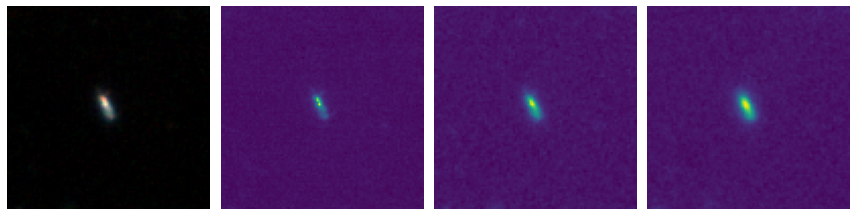

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


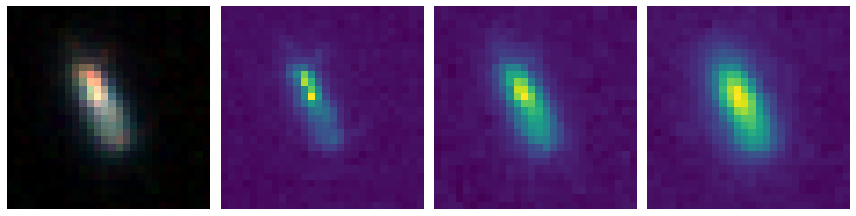

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


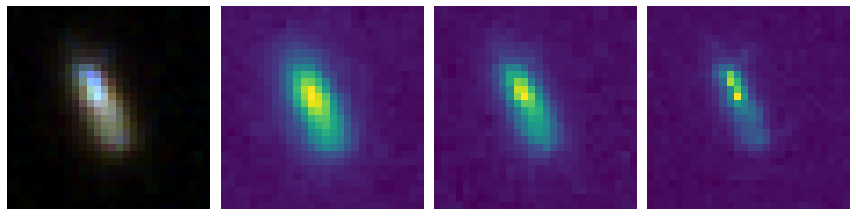

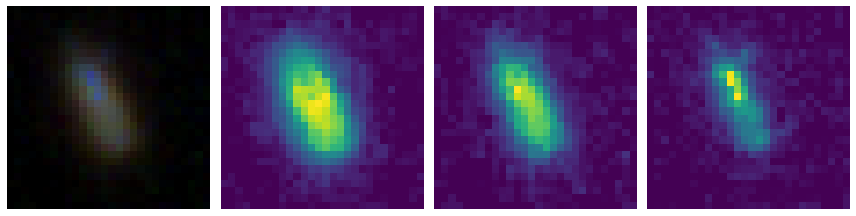

In [8]:
buat_plot_3_filter(data_asli[1000])
buat_plot_3_filter(data_bgr[1000])
buat_plot_3_filter(data_unnorm[1000])
buat_plot_3_filter(data[1000])

In [11]:
class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon


In [12]:
latent_dim = 25
 
encoder_inputs = keras.Input(shape=(28, 28, 3))
x = layers.Conv2D(8, 3, activation="relu", padding='same')(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, 3, activation="relu", padding='same')(x)
x = layers.Conv2D(64, 3, activation="relu", padding='same')(x)
x = layers.Conv2D(128, 3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)                                
x = layers.Dense(256, activation="sigmoid")(x)


mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 8)    224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 16)   1168        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d_1[0][0]']               
                                                                                            

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_1 (Dense)             (None, 6272)              163072    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 7, 7, 64)         73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 7, 7, 32)         1846

In [14]:
def compute_kernel(x, y):
    x_size = K.shape(x)[0]
    y_size = K.shape(y)[0]
    dim = K.shape(x)[1]
    tiled_x = K.tile(K.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
    tiled_y = K.tile(K.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
    return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, 'float32'))

class VAE(keras.Model):
    def __init__(self, encoder, decoder, loss_type="KL", beta=1 , **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_type = loss_type
        self.beta = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.regularization_loss_tracker = keras.metrics.Mean(name="regularization_loss")

    @property    
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.regularization_loss_tracker,
        ]


    def compute_mmd(self, x, y):
    
        x_kernel = compute_kernel(x, x)
        y_kernel = compute_kernel(y, y)
        xy_kernel = compute_kernel(x, y)
        return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel)
    

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean,log_var,z = self.encoder(data) 
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2),))
                
            if self.loss_type == "KL":
                regularization_loss = -0.5 * self.beta * (1 + log_var - tf.square(mean) - tf.exp(log_var))
                regularization_loss = tf.reduce_mean(tf.reduce_sum(regularization_loss, axis=1))          
                
            elif self.loss_type == "MMD":   
                true_samples = tf.random.normal(tf.shape(z))
                regularization_loss = self.compute_mmd(true_samples, z)
                
                
            
            total_loss = reconstruction_loss + regularization_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.regularization_loss_tracker.update_state(regularization_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "regularization_loss": self.regularization_loss_tracker.result(),
        }


# Pemilihan Data

Opsi data: data asli (100x100), data trimmed (28x28), data urut filter (RGB), data normalized

In [19]:
data.shape

(15130, 28, 28, 3)

In [20]:
vae = VAE(encoder, decoder, loss_type= "MMD")
vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(data, epochs=50, batch_size=64)

history = vae.fit(data, epochs=50, batch_size=64)


Epoch 1/50
237/237 [==============================] - 39s 157ms/step - loss: 31.2733 - reconstruction_loss: 11.0873 - regularization_loss: 0.0897
Epoch 2/50
237/237 [==============================] - 40s 167ms/step - loss: 2.2090 - reconstruction_loss: 1.8941 - regularization_loss: 0.0305
Epoch 3/50
237/237 [==============================] - 41s 174ms/step - loss: 1.3918 - reconstruction_loss: 1.2893 - regularization_loss: 0.0167
Epoch 4/50
237/237 [==============================] - 40s 169ms/step - loss: 1.0951 - reconstruction_loss: 1.0869 - regularization_loss: 0.0122
Epoch 5/50
237/237 [==============================] - 40s 170ms/step - loss: 1.0707 - reconstruction_loss: 1.0314 - regularization_loss: 0.0119
Epoch 6/50
237/237 [==============================] - 40s 169ms/step - loss: 0.9599 - reconstruction_loss: 0.9317 - regularization_loss: 0.0103
Epoch 7/50
237/237 [==============================] - 41s 171ms/step - loss: 0.9244 - reconstruction_loss: 0.8899 - regularization_los

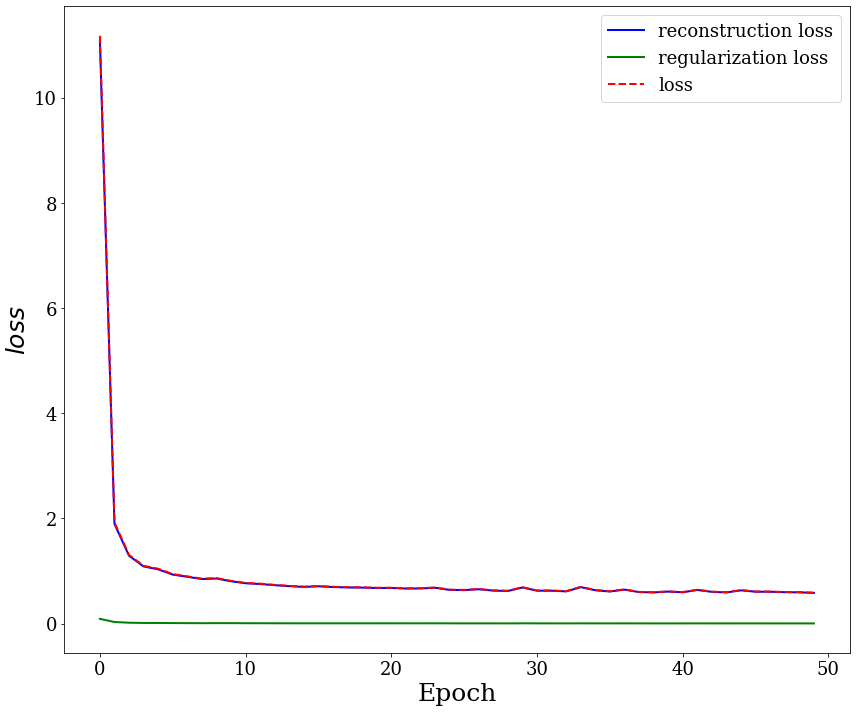

In [21]:
LOSS = history.history["loss"]
rec_loss = history.history["reconstruction_loss"]
reg_loss = history.history["regularization_loss"]

%matplotlib inline

fig = plt.figure(figsize=(12, 10))
plt.plot(rec_loss, label="reconstruction loss", lw=2, ls='-', c='b')
plt.plot(reg_loss, label="regularization loss", lw=2, ls='-', c='g')
plt.plot(LOSS, label="loss", lw=2, ls='--', c='r')
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('$loss$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('loss_plot.png')
plt.show()

1/1 [==============================] - 0s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


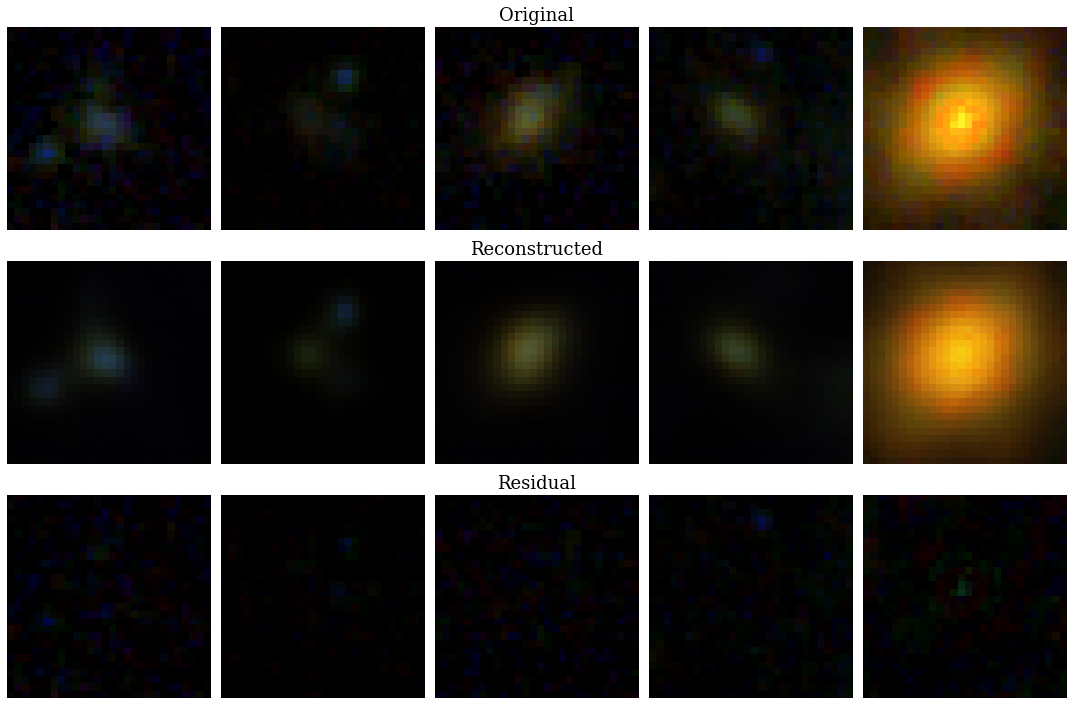

In [26]:
def plot_reconstructed_images(vae, data, n):
    indices = np.random.choice(len(data), n, replace=False)
    samples = data[indices]

    encoded = vae.encoder.predict(samples)
    z = encoded[2]
    reconstructed = vae.decoder.predict(z)

    # Plot
    fig, axes = plt.subplots(3, n, figsize=(n*3,10))

    for i in range(n):
        axes[0, i].imshow(samples[i], cmap='gray')
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructed[i], cmap='gray')
        axes[1, i].axis("off")

        residual = samples[i] - reconstructed[i]
        axes[2, i].imshow(residual, cmap='seismic')
        axes[2, i].axis("off")

    axes[0, 2].set_title("Original", fontsize=18)
    axes[1, 2].set_title("Reconstructed", fontsize=18)
    axes[2, 2].set_title("Residual", fontsize=18)

    plt.tight_layout()
    plt.show()
    
plot_reconstructed_images(vae, data, n=5)


In [27]:
reconstructed = vae.decoder.predict(vae.encoder.predict(data)[2])

473/473 [==============================] - 5s 11ms/step


In [28]:
reconstructed.shape

(15130, 28, 28, 3)

# Check Sample of Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


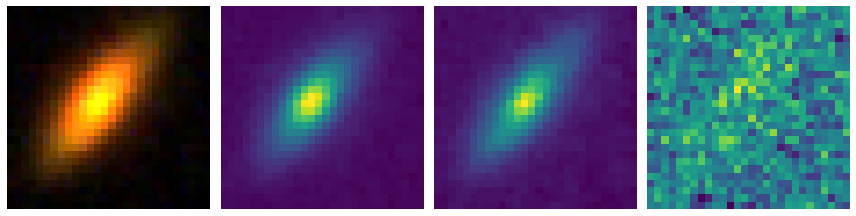

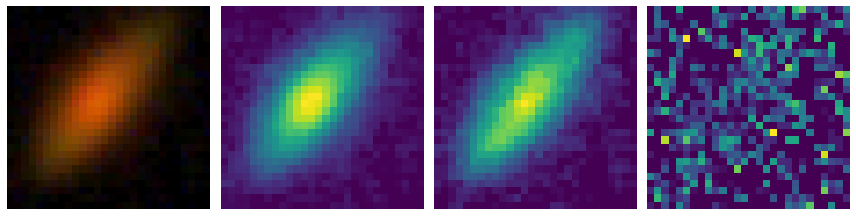

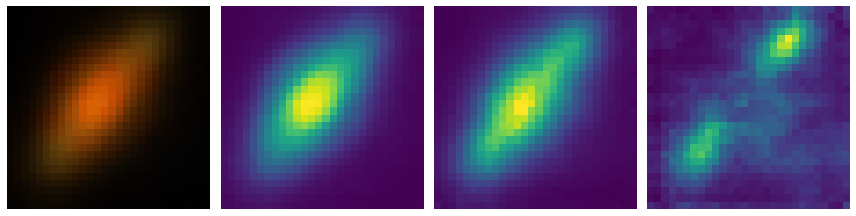

In [66]:
buat_plot_3_filter(data_unnorm[11689])
buat_plot_3_filter(data[11689])
buat_plot_3_filter(reconstructed[11689])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


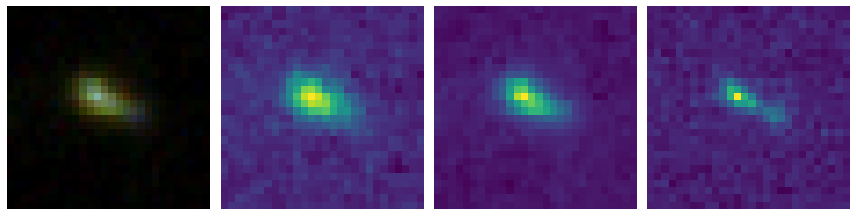

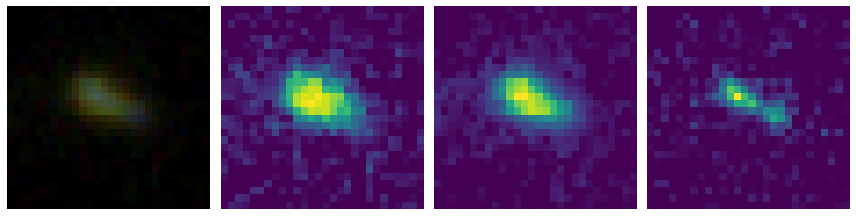

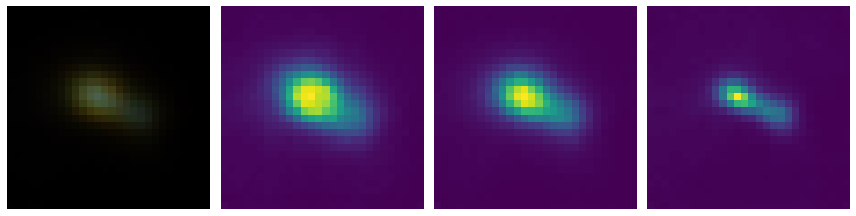

In [84]:
buat_plot_3_filter(data_unnorm[2945])
buat_plot_3_filter(data[2945])
buat_plot_3_filter(reconstructed[2945])